In [88]:
using Pkg
Pkg.develop(path="../apuu")

using Revise
using apuu.RobotEnv2D: POMDPscenario, InitParticleBelief, SampleMotionModel, GenerateObservation, ObsLikelihood, scatterParticles!, GenerateObservationFromBeacons, ObsFromBeaconsLikelihood, PosteriorParticleBeliefBeacons
using apuu.ParticleFilter: ParticleBelief, PropagateParticleBelief, PosteriorParticleBelief, ResampleParticles
using apuu.Paths: HW2_PLOTS

using Revise
using Distributions
using Random
using LinearAlgebra
using Plots
using StatsPlots
using Parameters
using StatsBase


   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


In [89]:
# definition of the random number generator with seed
ID = 318803129
rng = MersenneTwister(ID)

# parameters
μ0 = [0.0,0.0]
Σ0 = I(2)
F = I(2)
Σw = 0.1^2 * I(2)
Σv = I(2)
d = 1.0



1.0

# Part 1

In [90]:
# 
n_particles = 10
xgt0 = [-0.5, -0.2] # ground truth initial location
ai = ones(2) # action of the action sequence
T = 10 # time steps

10

## (h) - i,ii

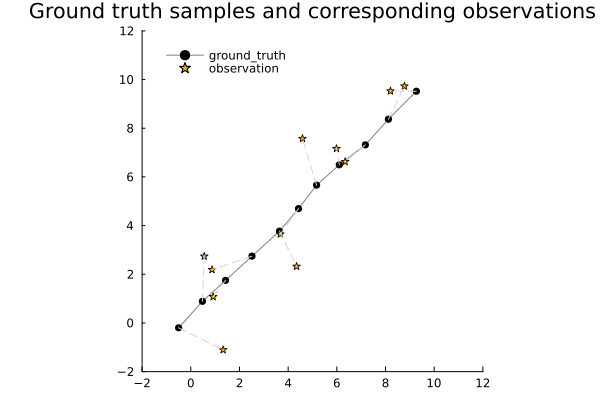

"/Users/jonathansomer/repos/apuu-hw2/plots/hw2/1h1_1h2_318803129.png"

In [103]:
# initialize the scenario
beacons = Matrix{Float64}(undef, 0, 2)  # 0 rows, 2 columns (empty matrix)
𝒫 = POMDPscenario(F=F, Σw=Σw, Σv=Σv, rng = rng, beacons=beacons, d=d)

# generate motion trajectory
τ = [xgt0] # trajectory
for i in 1:T
    push!(τ, SampleMotionModel(𝒫, ai, τ[end]))
end
τ = hcat(τ...)'  # convert to matrix form

# generate observation trajectory
τ_obs = []
for i in 1:T+1
    push!(τ_obs, GenerateObservation(𝒫, τ[i,:]))
end
τ_obs = hcat(τ_obs...)'  # convert to matrix form


# plot ground truth trajectory:
pl_gt = plot(τ[:,1], τ[:,2], 
             label="ground_truth", 
             markershape=:circle, 
             markercolor=:black,
             linecolor=:gray, 
             linestyle=:solid, 
             title="Ground truth samples and corresponding observations",
             grid=false,
             background_color_legend=nothing,  # No legend background
             foreground_color_legend=nothing
        )

# plot observations:
scatter!(
    pl_gt, 
    τ_obs[:,1], τ_obs[:,2], 
    label="observation", 
    markercolor=:orange, 
    markershape=:star5,
)            

# Draw lines connecting each GT point to its observation
for i in 1:T+1    
    plot!(pl_gt, 
          [τ[i,1], τ_obs[i,1]], 
          [τ[i,2], τ_obs[i,2]],
          color=:lightgray, 
          label="", 
          linewidth=1,
          linestyle=:dash)
end

plot!(pl_gt, aspect_ratio=:equal)
xlims!(pl_gt, -2,12)
ylims!(pl_gt, -2,12)

display(pl_gt)
savefig(pl_gt, joinpath(HW2_PLOTS, "1h1_1h2_$ID.png"))

# (h) iii - Belief propogation without observation update

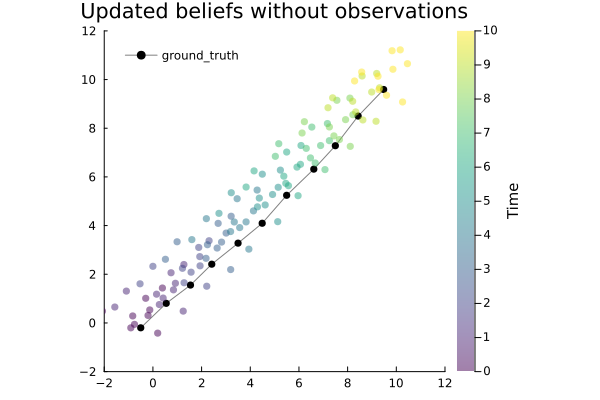

"/Users/jonathansomer/repos/apuu-hw2/plots/hw2/1h3_318803129.png"

In [92]:
# initialize particle belief
b0 = InitParticleBelief(n_particles, μ0, Σ0)


beliefs = Vector{ParticleBelief}(undef, T+1)
beliefs[1] = b0
for t in 1:T
    beliefs[t+1] = PropagateParticleBelief(𝒫, beliefs[t], ai, SampleMotionModel)
end

# plot the actual trajectory and the propagated particle beliefs with colorbar
pl_beliefs = plot(τ[:,1], τ[:,2], 
                  label="ground_truth", 
                  markershape=:circle, 
                  markercolor=:black,
                  linecolor=:gray, 
                  linestyle=:solid, 
                  title="Updated beliefs without observations", 
                  color=:black, 
                  aspect_ratio=:equal,
                  xlims=(-2, 12),
                  ylims=(-2, 12),
                  grid=false,
                  background_color_legend=nothing,  # No legend background
                  foreground_color_legend=nothing,
                  colorbar_title="Time")

for t in 1:T+1
    belief = beliefs[t]
    x = [particle[1] for particle in belief.particles]
    y = [particle[2] for particle in belief.particles]
    z = fill(t-1, length(x))  # Time value for each particle
    
    scatter!(pl_beliefs, x, y, 
             zcolor=z,
             markershape=:circle, 
             markersize=4,
             markerstrokewidth=0, 
             c=:viridis,
             clims=(0, T),
             alpha=0.5, 
             label="",
             colorbar=true)
end

display(pl_beliefs)
savefig(pl_beliefs, joinpath(HW2_PLOTS, "1h3_$ID.png"))

# (h) iv - belief update with observations

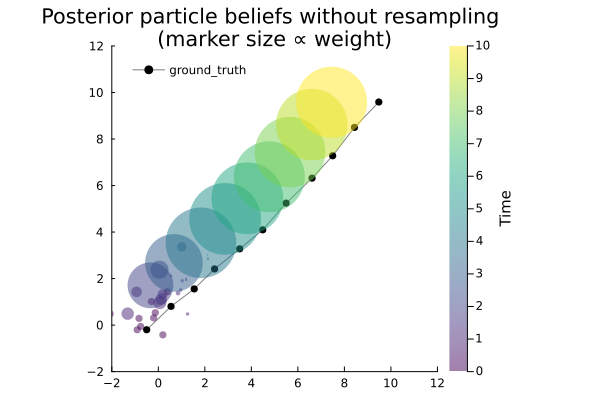

"/Users/jonathansomer/repos/apuu-hw2/plots/hw2/1h4_318803129.png"

In [93]:
beliefs_upd = Vector{ParticleBelief}(undef, T+1)
beliefs_upd[1] = b0
for t in 1:T
    beliefs_upd[t+1] = PosteriorParticleBelief(𝒫, beliefs_upd[t], ai, τ_obs[t,:], SampleMotionModel, ObsLikelihood)
end

# plot the actual trajectory and the updated particle beliefs with colorbar
pl_beliefs_upd = plot(τ[:,1], τ[:,2], 
                      label="ground_truth", 
                      markershape=:circle, 
                      markercolor=:black,
                      linecolor=:gray, 
                      linestyle=:solid, 
                      title="Posterior particle beliefs without resampling \n(marker size ∝ weight)", 
                      color=:black, 
                      aspect_ratio=:equal,
                      xlims=(-2, 12),
                      ylims=(-2, 12),
                      background_color_legend=nothing,  # No legend background
                      foreground_color_legend=nothing,
                      grid=false,
                      colorbar_title="Time")

for t in 1:T+1
    belief = beliefs_upd[t]
    n_particles = length(belief.particles)
    x = [particle[1] for particle in belief.particles]
    y = [particle[2] for particle in belief.particles]
    w = belief.weights
    z = fill(t-1, length(x))  # Time value for each particle
    
    scatter!(pl_beliefs_upd, x, y, 
             zcolor=z,
             markershape=:circle, 
             markersize=w .* n_particles*4,
             markerstrokewidth=0, 
             c=:viridis,
             clims=(0, T),
             alpha=0.5, 
             label="",
             colorbar=true)
end

display(pl_beliefs_upd)
savefig(pl_beliefs_upd, joinpath(HW2_PLOTS, "1h4_$ID.png"))

# (h) v - belief update with observations and resampling

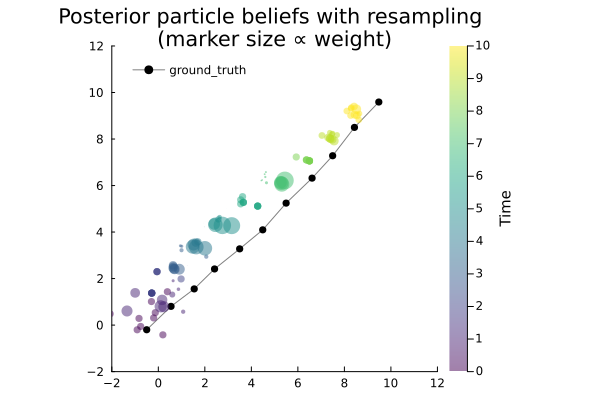

"/Users/jonathansomer/repos/apuu-hw2/plots/hw2/1h_5_318803129.png"

In [94]:
ess_threshold = n_particles / 2.0
beliefs_resamp = Vector{ParticleBelief}(undef, T+1)
beliefs_resamp[1] = b0
for t in 1:T
    b_upd = PosteriorParticleBelief(𝒫, beliefs_resamp[t], ai, τ_obs[t,:], SampleMotionModel, ObsLikelihood)
    beliefs_resamp[t+1] = ResampleParticles(𝒫, b_upd, ess_threshold)
end

# plot the actual trajectory and the resampled particle beliefs with colorbar
pl_beliefs_resamp = plot(τ[:,1], τ[:,2], 
                         label="ground_truth", 
                         markershape=:circle, 
                         markercolor=:black,
                         linecolor=:gray, 
                         linestyle=:solid, 
                         title="Posterior particle beliefs with resampling \n(marker size ∝ weight)", 
                         color=:black, 
                         aspect_ratio=:equal,
                         xlims=(-2, 12),
                         ylims=(-2, 12),
                         grid=false,
                         background_color_legend=nothing,  # No legend background
                         foreground_color_legend=nothing,
                         colorbar_title="Time")

for t in 1:T+1
    belief = beliefs_resamp[t]
    n_particles = length(belief.particles)
    x = [particle[1] for particle in belief.particles]
    y = [particle[2] for particle in belief.particles]
    w = belief.weights
    z = fill(t-1, length(x))  # Time value for each particle
    
    scatter!(pl_beliefs_resamp, x, y, 
             zcolor=z,
             markershape=:circle, 
             markersize=w .* n_particles*4,
             markerstrokewidth=0, 
             c=:viridis,
             clims=(0, T),
             alpha=0.5, 
             label="",
             colorbar=true)
end

display(pl_beliefs_resamp)
savefig(pl_beliefs_resamp, joinpath(HW2_PLOTS, "1h_5_$ID.png"))

# Part 2

## 2-a

The corresponding observation model is:

$z_{\text{rel}} = x_{\text{robot}}- x_{\text{beacon}} + v$

$v \sim N(0, Σ_v)$

Where we do not receive an observation unless $$||x_{\text{robot}} - x_{\text{beacon}}||_2 < d$$


## 2-b

In [95]:
# initialize the scenario
beacons = Matrix{Float64}([1 1; 4 4; 10 10])
𝒫 = POMDPscenario(F=F, Σw=Σw, Σv=Σv, rng = rng, beacons=beacons, d=d)

n = 10
x_matrix = Matrix{Float64}(undef, n, 2)  # Assuming 2D observations

for i in 1:n
    x = GenerateObservationFromBeacons(𝒫, [4., 3.1])
    x_matrix[i, :] = x[1]
    println(x)
end

mean(x_matrix, dims=1)

([2.0352256852704023, -1.519925657451358], 2)
([2.427489838680912, -1.6649522627701705], 2)
([0.5036381614566616, 0.16781786233648144], 2)
([-1.62659768454551, 0.6336985816929233], 2)
([0.6253704412964471, -1.3424538229648348], 2)
([-0.12896047227796173, -1.2623851199647949], 2)
([-1.1921731929436306, -0.9920701655163758], 2)
([1.0318044343661417, -1.7034372486692009], 2)
([-0.2247088392135068, -2.808488848205661], 2)
([-0.08645307636629926, -1.1239274820587246], 2)


1×2 Matrix{Float64}:
 0.336464  -1.16161

## 2-c

In [96]:
# when x is on the beacon, low relative observation has higher likelihood:
@assert ObsFromBeaconsLikelihood(𝒫, z_rel=[0.0, 0.0], robot_x=[1.0, 1.0]) > ObsFromBeaconsLikelihood(𝒫, z_rel=[0.5, 0.0], robot_x=[1.0, 1.0])
@assert ObsFromBeaconsLikelihood(𝒫, z_rel=[0.1, 0.1], robot_x=[1.0, 1.0]) > ObsFromBeaconsLikelihood(𝒫, z_rel=[0.5, 0.5], robot_x=[1.0, 1.0])

# when x is far from the beacon, high relative observation has higher likelihood:
@assert ObsFromBeaconsLikelihood(𝒫, z_rel=[0.0, 0.5], robot_x=[1.0, 1.5]) > ObsFromBeaconsLikelihood(𝒫, z_rel=[0.0, 0.0], robot_x=[1.0, 1.5])
@assert ObsFromBeaconsLikelihood(𝒫, z_rel=[0.0, 0.5], robot_x=[4.0, 4.5]) > ObsFromBeaconsLikelihood(𝒫, z_rel=[0.0, 0.4], robot_x=[4.0, 4.5])

# 2 - d

In [97]:

# test one particle far, another on a beacon - entire weight on the one on the beacon
display("Test one particle far, another on a beacon - entire weight on the one on the beacon")
beacons = Matrix{Float64}([1 1; 4 4; 10 10])
𝒫 = POMDPscenario(F=F, Σw=Σw, Σv=Σv, rng = rng, beacons=beacons, d=d)
b = ParticleBelief(particles=[[100.0, 100.0], [3.0, 3.0]], weights=[0.5, 0.5])
a = [1.0, 1.0] # move the second particle onto a beacon
z‵ = [0., 0.]

display(b)
display(PosteriorParticleBeliefBeacons(𝒫, b, a, z‵))

# test one particle closer than the other to a beacon
display("Test one particle closer than the other to a beacon")
beacons = Matrix{Float64}([1 1; 4 4; 10 10])
𝒫 = POMDPscenario(F=F, Σw=Σw, Σv=Σv, rng = rng, beacons=beacons, d=d)
b = ParticleBelief(particles=[[2.9, 2.9], [3.0, 3.0]], weights=[0.5, 0.5])
a = [1.0, 1.0] # move the second particle onto a beacon
z‵ = [0., 0.]


display(b)
display(PosteriorParticleBeliefBeacons(𝒫, b, a, z‵))


"Test one particle far, another on a beacon - entire weight on the one on the beacon"

ParticleBelief
  particles: Array{Vector{Float64}}((2,))
  weights: Array{Float64}((2,)) [0.5, 0.5]


ParticleBelief
  particles: Array{Vector{Float64}}((2,))
  weights: Array{Float64}((2,)) [0.0, 1.0]


"Test one particle closer than the other to a beacon"

ParticleBelief
  particles: Array{Vector{Float64}}((2,))
  weights: Array{Float64}((2,)) [0.5, 0.5]


ParticleBelief
  particles: Array{Vector{Float64}}((2,))
  weights: Array{Float64}((2,)) [0.49978517075146944, 0.5002148292485307]


# 2E

In [98]:
# define beacon locations:
beacon_grid = [0, 4.5, 9]
beacons = hcat([[x, y] for x in beacon_grid, y in beacon_grid]...)'

# define belief:
μ0 = zeros(2)
Σ0 = I(2)
N = 10
b0 = InitParticleBelief(N, μ0, Σ0)

# define POMDP scenario:
Σw = 0.1^2 * I(2)
Σv = I(2)
X0 = [-0.5, -0.2]
ai = ones(2)
𝒫 = POMDPscenario(F=F, Σw=Σw, Σv=Σv, rng = rng, beacons=beacons, d=d)

POMDPscenario
  F: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Σw: Array{Float64}((2, 2)) [0.010000000000000002 0.0; 0.0 0.010000000000000002]
  Σv: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  rng: MersenneTwister
  beacons: Array{Float64}((9, 2)) [0.0 0.0; 4.5 0.0; … ; 4.5 9.0; 9.0 9.0]
  d: Float64 1.0


# 2-i

In [99]:
 GenerateObservationFromBeacons(𝒫, τ[1,:])[1]

2-element Vector{Float64}:
  1.0930076063227072
 -2.1964571544080087

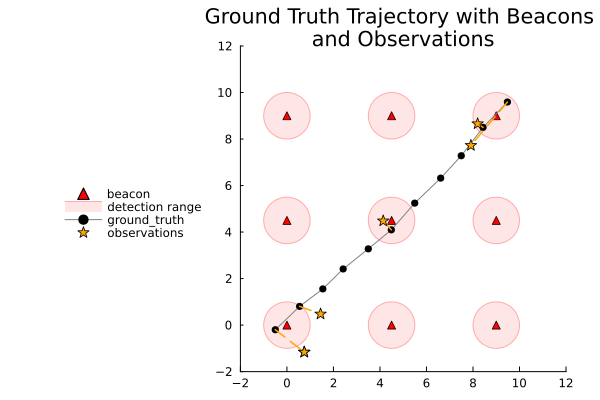

"/Users/jonathansomer/repos/apuu-hw2/plots/hw2/2e1_trajectory_beacons_observations_318803129.png"

In [100]:
# generate observation trajectory
τ_obs_beacons = []
for i in 1:T+1
    obs = GenerateObservationFromBeacons(𝒫, τ[i,:])
    if obs != nothing
        push!(τ_obs_beacons, obs[1])
    else
        push!(τ_obs_beacons, [NaN, NaN])  # or some other placeholder for no observation
    end
end
τ_obs_beacons = hcat(τ_obs_beacons...)'  # convert to matrix form

# plot ground truth trajectory with beacons and observations:
# Plot beacons first (in the back)
pl_beacons = scatter(beacons[:,1], beacons[:,2], 
                     label="beacon", 
                     markershape=:utriangle, 
                     markersize=4,
                     markercolor=:red,
                     title="Ground Truth Trajectory with Beacons \nand Observations",
                     grid=false,
                     aspect_ratio=:equal,
                     xlims=(-2, 12),
                     ylims=(-2, 12),
                     legend=:outerleft,
                     background_color_legend=nothing,
                     foreground_color_legend=nothing)

# Add detection radius circles around each beacon
θ = range(0, 2π, length=100)
for i in 1:size(beacons, 1)
    x_circle = beacons[i, 1] .+ 𝒫.d * cos.(θ)
    y_circle = beacons[i, 2] .+ 𝒫.d * sin.(θ)
    plot!(pl_beacons, x_circle, y_circle, 
          fillrange=beacons[i, 2],
          fillalpha=0.1, 
          fillcolor=:red,
          linecolor=:red,
          linealpha=0.3,
          linewidth=1,
          label=i==1 ? "detection range" : "")
end

# Plot ground truth trajectory on top
plot!(pl_beacons, τ[:,1], τ[:,2], 
      label="ground_truth", 
      markershape=:circle, 
      markercolor=:black,
      linecolor=:gray, 
      linestyle=:solid)

# Plot observations (convert relative to absolute positions)
# First pass: plot all connections and observations without label
for i in 1:size(τ_obs_beacons, 1)
    if !isnan(τ_obs_beacons[i, 1])
        # The observation is relative: z_rel = robot - beacon
        # To find beacon position: beacon = robot - z_rel
        obs_end = τ[i, :] .- τ_obs_beacons[i, :]  # This gives approximate beacon location
        
        # Draw line from robot to sensed beacon location
        plot!(pl_beacons, 
              [τ[i,1], obs_end[1]], 
              [τ[i,2], obs_end[2]],
              color=:orange, 
              label="", 
              linewidth=1.5,
              linestyle=:dash)
              
        # Plot observation marker
        scatter!(pl_beacons, [obs_end[1]], [obs_end[2]], 
                 markercolor=:orange, 
                 markershape=:star5,
                 markersize=6,
                 label="")
    end
end

# legend
obs_indices = findall(x -> !isnan(x), τ_obs_beacons[:, 1])
if !isempty(obs_indices)
    i = obs_indices[1]
    obs_end = τ[i, :] .- τ_obs_beacons[i, :]
    scatter!(pl_beacons, [obs_end[1]], [obs_end[2]], 
             markercolor=:orange, 
             markershape=:star5,
             markersize=6,
             label="observations")
end

display(pl_beacons)
savefig(pl_beacons, joinpath(HW2_PLOTS, "2e1_trajectory_beacons_observations_$ID.png"))

# 2e - ii posterior belief without resampling

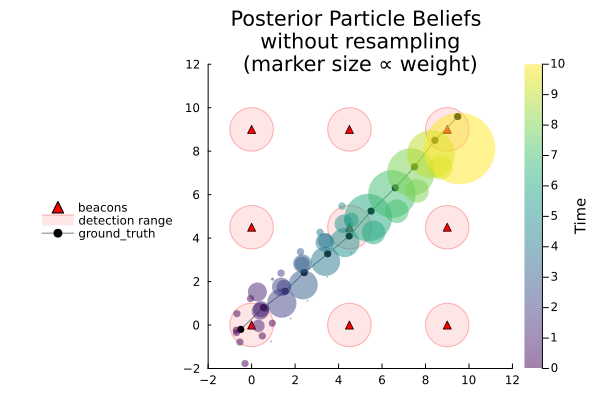

"/Users/jonathansomer/repos/apuu-hw2/plots/hw2/2e2_beliefs_without_resampling_318803129.png"

In [101]:
beliefs_upd = Vector{ParticleBelief}(undef, T+1)
beliefs_upd[1] = b0
for t in 1:T
    obs = τ_obs_beacons[t,:]
    if any(isnan.(obs))
        # no observation received, skip update
        beliefs_upd[t+1] = PropagateParticleBelief(𝒫, beliefs_upd[t], ai, SampleMotionModel)
        continue
    else
        beliefs_upd[t+1] = PosteriorParticleBelief(𝒫, beliefs_upd[t], ai, obs, SampleMotionModel, ObsLikelihood)
    end
end

# Plot: beacons, ground truth trajectory, and particle beliefs with colorbar
# Plot beacons first (in the back)
pl_2e = scatter(beacons[:,1], beacons[:,2], 
                label="beacons", 
                markershape=:utriangle, 
                markersize=4,
                markercolor=:red,
                title="Posterior Particle Beliefs \n without resampling \n(marker size ∝ weight)",
                grid=false,
                aspect_ratio=:equal,
                xlims=(-2, 12),
                ylims=(-2, 12),
                legend=:outerleft,
                background_color_legend=nothing,
                foreground_color_legend=nothing,
                colorbar_title="Time")

# Add detection radius circles around each beacon
θ = range(0, 2π, length=100)
for i in 1:size(beacons, 1)
    x_circle = beacons[i, 1] .+ 𝒫.d * cos.(θ)
    y_circle = beacons[i, 2] .+ 𝒫.d * sin.(θ)
    plot!(pl_2e, x_circle, y_circle, 
          fillrange=beacons[i, 2],
          fillalpha=0.1, 
          fillcolor=:red,
          linecolor=:red,
          linealpha=0.3,
          linewidth=1,
          label=i==1 ? "detection range" : "")
end

# Plot ground truth trajectory
plot!(pl_2e, τ[:,1], τ[:,2], 
      label="ground_truth", 
      markershape=:circle, 
      markercolor=:black,
      linecolor=:gray, 
      linestyle=:solid)

# Plot particle beliefs with colorbar
for t in 1:T+1
    belief = beliefs_upd[t]
    n_particles = length(belief.particles)
    x = [particle[1] for particle in belief.particles]
    y = [particle[2] for particle in belief.particles]
    w = belief.weights
    z = fill(t-1, length(x))  # Time value for each particle
    
    scatter!(pl_2e, x, y, 
             zcolor=z,
             markershape=:circle, 
             markersize=w .* n_particles*4,
             markerstrokewidth=0, 
             c=:viridis,
             clims=(0, T),
             alpha=0.5, 
             label="",
             colorbar=true)
end

display(pl_2e)
savefig(pl_2e, joinpath(HW2_PLOTS, "2e2_beliefs_without_resampling_$ID.png"))

# 2e - iii

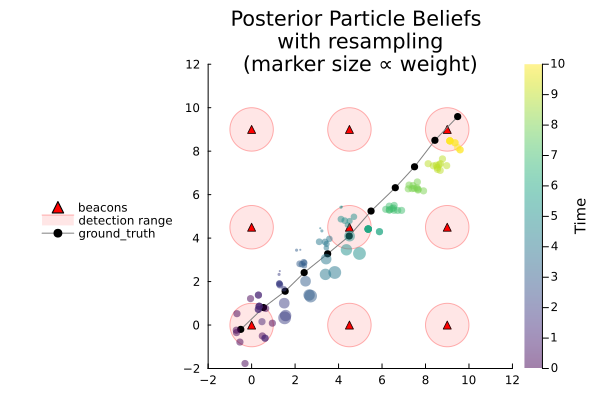

"/Users/jonathansomer/repos/apuu-hw2/plots/hw2/2e3_beliefs_with_resampling_318803129.png"

In [102]:
beliefs_upd = Vector{ParticleBelief}(undef, T+1)
beliefs_upd[1] = b0
for t in 1:T
    obs = τ_obs_beacons[t,:]
    if any(isnan.(obs))
        # no observation received, skip update
        beliefs_upd[t+1] = PropagateParticleBelief(𝒫, beliefs_upd[t], ai, SampleMotionModel)
        continue
    else
        next_belief = PosteriorParticleBelief(𝒫, beliefs_upd[t], ai, obs, SampleMotionModel, ObsLikelihood)
        beliefs_upd[t+1] = ResampleParticles(𝒫, next_belief, n_particles/2)
    end
end

# Plot: beacons, ground truth trajectory, and particle beliefs with colorbar
# Plot beacons first (in the back)
pl_2e = scatter(beacons[:,1], beacons[:,2], 
                label="beacons", 
                markershape=:utriangle, 
                markersize=4,
                markercolor=:red,
                title="Posterior Particle Beliefs \n with resampling \n(marker size ∝ weight)",
                grid=false,
                aspect_ratio=:equal,
                xlims=(-2, 12),
                ylims=(-2, 12),
                legend=:outerleft,
                background_color_legend=nothing,
                foreground_color_legend=nothing,
                colorbar_title="Time")

# Add detection radius circles around each beacon
θ = range(0, 2π, length=100)
for i in 1:size(beacons, 1)
    x_circle = beacons[i, 1] .+ 𝒫.d * cos.(θ)
    y_circle = beacons[i, 2] .+ 𝒫.d * sin.(θ)
    plot!(pl_2e, x_circle, y_circle, 
          fillrange=beacons[i, 2],
          fillalpha=0.1, 
          fillcolor=:red,
          linecolor=:red,
          linealpha=0.3,
          linewidth=1,
          label=i==1 ? "detection range" : "")
end

# Plot ground truth trajectory
plot!(pl_2e, τ[:,1], τ[:,2], 
      label="ground_truth", 
      markershape=:circle, 
      markercolor=:black,
      linecolor=:gray, 
      linestyle=:solid)

# Plot particle beliefs with colorbar
for t in 1:T+1
    belief = beliefs_upd[t]
    n_particles = length(belief.particles)
    x = [particle[1] for particle in belief.particles]
    y = [particle[2] for particle in belief.particles]
    w = belief.weights
    z = fill(t-1, length(x))  # Time value for each particle
    
    scatter!(pl_2e, x, y, 
             zcolor=z,
             markershape=:circle, 
             markersize=w .* n_particles*4,
             markerstrokewidth=0, 
             c=:viridis,
             clims=(0, T),
             alpha=0.5, 
             label="",
             colorbar=true)
end

display(pl_2e)
savefig(pl_2e, joinpath(HW2_PLOTS, "2e3_beliefs_with_resampling_$ID.png"))

# 2f - i - why resample?

If we don't resample, eventually the entire weight will be place on one particle. Particles that took low probability trajectories will have low likelihoods, and hence low weights. Instea of simulating forward steps and likelihoods for particles that effectively don't contribute to the belief, we resample according to likelihood and focus our computational resources on particles that are more likely to represent the true state. We get a better approximation of the posterior belief with fewer particles this way.

# 2f - ii Resampling too often or too little

Too often:
Generally when sampling n samples with replacement we sample about 1-1/e of the original samples (63%). And we certainly can't sample more than n samples. As a result we lose diversity. While the approach is unbiased it increases variance - we may end up with many copies of a few particles and miss out on other regions of the state space.

Too little:
If we don't resample enough, we may end up with many particles with very low weights. These particles don't contribute to the belief and waste computational resources. If we never resample, eventually all weight will be placed on one particle and we will have a very poor approximation of the posterior belief.

# 2f - iii Alternative strategy:

We can define a minimal weight, and resample only particles with weight below this threshold, keeping all others.

We heuristically set the minimal threshold to 1/(3*n_particles).

In this case, for each particle we resample, we choose one existing particle and copy it, but divide its weight in half. Splitting a particle while splitting its weight maintains the distribution. As we only remove low weight particles the distribution is approximately maintained.

Thus, we get approximately the same distribution, but additional copies of high weight particles. This implementation ensures that we never lose high weight particles, while still resampling low weight particles to focus computational resources on more likely states.

In this implementation, we remove the lowest weight particle and split the highest weight particle. This modular function can be called multiple times to resample more particles as needed.


In [143]:
function ResampleLowestWeightParticle(𝒫, b::ParticleBelief, min_weight_threshold::Float64)::ParticleBelief
    # Don't resample if lowest weight is above threshold
    lowest_weight = minimum(b.weights)
    
    if lowest_weight > min_weight_threshold
        return b  # No resampling needed
    end
    
    # Make copies of particles and weights for modification
    particles = copy(b.particles)
    weights = copy(b.weights)
    
    # Find indices of min and max weight particles
    min_idx = argmin(weights)
    max_idx = argmax(weights)
    
    # Store the max weight particle and weight before deletion
    max_particle = particles[max_idx]
    max_weight = weights[max_idx]
    
    # Remove lowest weight particle and its weight
    deleteat!(particles, min_idx)
    deleteat!(weights, min_idx)
    
    # Adjust max_idx if it was after min_idx (indices shift after deletion)
    if max_idx > min_idx
        max_idx -= 1
    end
    
    # Split the highest weight particle:
    # Divide the existing particle's weight in half
    weights[max_idx] = max_weight / 2.0
    
    # Add a copy of the highest weight particle with half the original weight
    push!(particles, copy(max_particle))
    push!(weights, max_weight / 2.0)
    
    # Normalize weights to sum to 1
    weights = weights / sum(weights)
    
    return ParticleBelief(particles=particles, weights=weights)
end

ResampleLowestWeightParticle (generic function with 2 methods)

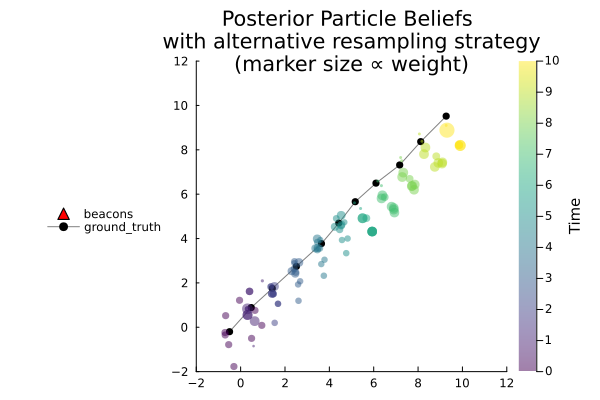

"/Users/jonathansomer/repos/apuu-hw2/plots/hw2/2f3_beliefs_with_alternative_resampling_strategy_318803129.png"

In [144]:
beliefs_upd = Vector{ParticleBelief}(undef, T+1)
beliefs_upd[1] = b0
for t in 1:T
    obs = τ_obs_beacons[t,:]
    if any(isnan.(obs))
        # no observation received, skip update
        beliefs_upd[t+1] = PropagateParticleBelief(𝒫, beliefs_upd[t], ai, SampleMotionModel)
        continue
    else
        next_belief = PosteriorParticleBelief(𝒫, beliefs_upd[t], ai, obs, SampleMotionModel, ObsLikelihood)
        for i in 1:4
            next_belief = ResampleLowestWeightParticle(𝒫, next_belief, 1/(3*n_particles))
        end
        beliefs_upd[t+1] = next_belief
    end
end

# Plot: beacons, ground truth trajectory, and particle beliefs with colorbar
# Plot beacons first (in the back)
pl_2e = scatter(beacons[:,1], beacons[:,2], 
                label="beacons", 
                markershape=:utriangle, 
                markersize=4,
                markercolor=:red,
                title="Posterior Particle Beliefs \n with alternative resampling strategy \n(marker size ∝ weight)",
                grid=false,
                aspect_ratio=:equal,
                xlims=(-2, 12),
                ylims=(-2, 12),
                legend=:outerleft,
                background_color_legend=nothing,
                foreground_color_legend=nothing,
                colorbar_title="Time")

# Add detection radius circles around each beacon
θ = range(0, 2π, length=100)
for i in 1:size(beacons, 1)
    x_circle = beacons[i, 1] .+ 𝒫.d * cos.(θ)
    y_circle = beacons[i, 2] .+ 𝒫.d * sin.(θ)
    plot!(pl_2e, x_circle, y_circle, 
          fillrange=beacons[i, 2],
          fillalpha=0.1, 
          fillcolor=:red,
          linecolor=:red,
          linealpha=0.3,
          linewidth=1,
          label=i==1 ? "detection range" : "")
end

# Plot ground truth trajectory
plot!(pl_2e, τ[:,1], τ[:,2], 
      label="ground_truth", 
      markershape=:circle, 
      markercolor=:black,
      linecolor=:gray, 
      linestyle=:solid)

# Plot particle beliefs with colorbar
for t in 1:T+1
    belief = beliefs_upd[t]
    n_particles = length(belief.particles)
    x = [particle[1] for particle in belief.particles]
    y = [particle[2] for particle in belief.particles]
    w = belief.weights
    z = fill(t-1, length(x))  # Time value for each particle
    
    scatter!(pl_2e, x, y, 
             zcolor=z,
             markershape=:circle, 
             markersize=w .* n_particles*4,
             markerstrokewidth=0, 
             c=:viridis,
             clims=(0, T),
             alpha=0.5, 
             label="",
             colorbar=true)
end

display(pl_2e)
savefig(pl_2e, joinpath(HW2_PLOTS, "2f3_beliefs_with_alternative_resampling_strategy_$ID.png"))